In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!pip install -q timm pytorch-lightning torchmetrics torchvision einops

In [9]:
import os, random
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import pytorch_lightning as pl
from torchmetrics.classification import MulticlassAccuracy
import timm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from einops import rearrange

In [10]:
DATASET_PATH = "/content/drive/MyDrive/dataset_nsfw_lite"
BATCH_SIZE = 8
IMG_SIZE = 160
NUM_CLASSES = 5
EPOCHS = 15
LR = 3e-4
EMBED_DIM = 192

In [11]:
train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.85,1.0)),
    transforms.ColorJitter(0.1,0.1,0.1,0.05),
    transforms.ToTensor(),
])

val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# ================= DATA =================
full_ds = datasets.ImageFolder(DATASET_PATH, transform=train_tf)
class_names = full_ds.classes

train_size = int(0.8 * len(full_ds))
val_size   = len(full_ds) - train_size
train_ds, val_ds = random_split(full_ds, [train_size, val_size])

val_ds.dataset.transform = val_tf

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("Classes:", class_names)
print("Train:", len(train_ds), "Val:", len(val_ds))

Classes: ['drawing', 'hentai', 'neutral', 'porn', 'sexy']
Train: 1200 Val: 300


In [12]:
class MobileNetDeiTHybrid(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # -------- CNN Backbone --------
        self.cnn = models.mobilenet_v3_small(pretrained=True)
        self.cnn_features = self.cnn.features   # feature extractor
        self.cnn_out_channels = 576              # mobilenet_v3_small output channels

        # Freeze CNN backbone (biar training cepat)
        for p in self.cnn_features.parameters():
            p.requires_grad = False

        # -------- Projection --------
        self.proj = nn.Conv2d(self.cnn_out_channels, EMBED_DIM, kernel_size=1)

        # -------- Mini DeiT Transformer --------
        self.deit = timm.create_model(
            "deit_tiny_patch16_224",
            pretrained=True,
            num_classes=0   # no head
        )

        # -------- Classification Head --------
        self.norm = nn.LayerNorm(EMBED_DIM)
        self.head = nn.Linear(EMBED_DIM, num_classes)

    def forward(self, x):
        # CNN feature extraction
        feat = self.cnn_features(x)  # [B, C, H, W]

        # projection to embedding dim
        feat = self.proj(feat)       # [B, EMBED, H, W]

        # flatten to tokens
        tokens = rearrange(feat, "b c h w -> b (h w) c")

        # transformer
        tokens = self.deit.blocks(tokens)
        tokens = self.norm(tokens)

        # global pooling
        pooled = tokens.mean(dim=1)

        # classification
        out = self.head(pooled)
        return out

# ================= LIGHTNING MODULE =================
class HybridLightning(pl.LightningModule):
    def __init__(self, num_classes, lr=3e-4):
        super().__init__()
        self.save_hyperparameters()

        self.model = MobileNetDeiTHybrid(num_classes)
        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        self.acc = MulticlassAccuracy(num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = self.acc(logits, y)

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = self.acc(logits, y)

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            filter(lambda p: p.requires_grad, self.parameters()),
            lr=self.hparams.lr,
            weight_decay=1e-4
        )

        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=EPOCHS
        )
        return [optimizer], [scheduler]

In [13]:
model = HybridLightning(NUM_CLASSES, LR)

trainer = pl.Trainer(
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    max_epochs=EPOCHS,
    precision=16,
    log_every_n_steps=10,
    accumulate_grad_batches=4
)

trainer.fit(model, train_loader, val_loader)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 149MB/s]


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

INFO:pytorch_lightning.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type                ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ MobileNetDeiTHybrid │  8.2 M │ train │     0 │
│ 1 │ criterion │ CrossEntropyLoss    │      0 │ train │     0 │
│ 2 │ acc       │ MulticlassAccuracy  │      0 │ train │     0 │
└───┴───────────┴─────────────────────┴────────┴───────┴───────┘

Trainable params: 7.3 M                                                                                            
Non-trainable params: 927 K                                                                                        
Total params: 8.2 M                                                                                                
Total estimated model params size (MB): 32                                                                         
Modules in train mode: 491                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.



Classification Report:

              precision    recall  f1-score   support

     drawing       0.66      0.74      0.70        53
      hentai       0.73      0.61      0.67        59
     neutral       0.68      0.77      0.72        57
        porn       0.75      0.80      0.77        64
        sexy       0.80      0.70      0.75        67

    accuracy                           0.72       300
   macro avg       0.72      0.72      0.72       300
weighted avg       0.73      0.72      0.72       300



<Figure size 700x700 with 0 Axes>

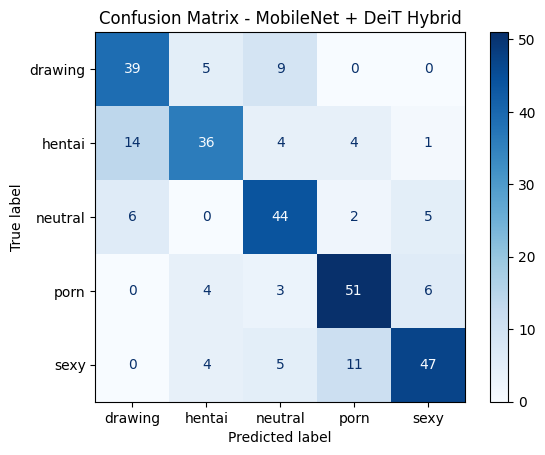

In [14]:
model.eval()
model.to(model.device)

all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(model.device)
        logits = model(x)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.numpy())

cm = confusion_matrix(all_labels, all_preds)

print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(7,7))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - MobileNet + DeiT Hybrid")
plt.show()